In [1]:
import kagglehub



c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")

print("Path to dataset files:", path)


100%|██████████| 159M/159M [00:48<00:00, 3.41MB/s] 

Extracting files...


Path to dataset files: C:\Users\KIIT\.cache\kagglehub\datasets\arshkon\linkedin-job-postings\versions\13


In [6]:
import os
import pandas as pd
import kagglehub

# Download dataset
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
print("Dataset downloaded to:", path)

# Define base dataset folder (ensure it matches the downloaded structure)
dataset_base_path = path  # No need to add "/13" again

# Verify if the dataset folder exists
if not os.path.exists(dataset_base_path):
    raise FileNotFoundError(f"Dataset path not found: {dataset_base_path}")

# Function to read all CSVs in subfolders and root folder
def load_all_csvs(base_path):
    dataframes = {}  # Dictionary to store DataFrames
    
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        
        # Load CSVs from root folder
        if item.endswith(".csv"):
            df_name = item.replace(".csv", "")
            try:
                dataframes[df_name] = pd.read_csv(item_path)
                print(f"Loaded: {df_name} ({dataframes[df_name].shape[0]} rows)")
            except Exception as e:
                print(f"Error loading {df_name}: {e}")
        
        # Load CSVs from subfolders
        elif os.path.isdir(item_path):
            for file in os.listdir(item_path):
                if file.endswith(".csv"):
                    file_path = os.path.join(item_path, file)
                    df_name = f"{item}_{file.replace('.csv', '')}"
                    try:
                        dataframes[df_name] = pd.read_csv(file_path)
                        print(f"Loaded: {df_name} ({dataframes[df_name].shape[0]} rows)")
                    except Exception as e:
                        print(f"Error loading {df_name}: {e}")
    
    return dataframes

# Load dataset
dfs = load_all_csvs(dataset_base_path)

# Example usage: Access the job postings data
df_postings = dfs.get("postings", None)
if df_postings is not None:
    print(df_postings.info())
    print(df_postings.head())
else:
    print("Job postings data not found!")



  



Dataset downloaded to: C:\Users\KIIT\.cache\kagglehub\datasets\arshkon\linkedin-job-postings\versions\13
Loaded: companies_companies (24473 rows)
Loaded: companies_company_industries (24375 rows)
Loaded: companies_company_specialities (169387 rows)
Loaded: companies_employee_counts (35787 rows)
Loaded: jobs_benefits (67943 rows)
Loaded: jobs_job_industries (164808 rows)
Loaded: jobs_job_skills (213768 rows)
Loaded: jobs_salaries (40785 rows)
Loaded: mappings_industries (422 rows)
Loaded: mappings_skills (35 rows)
Loaded: postings (123849 rows)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null 

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


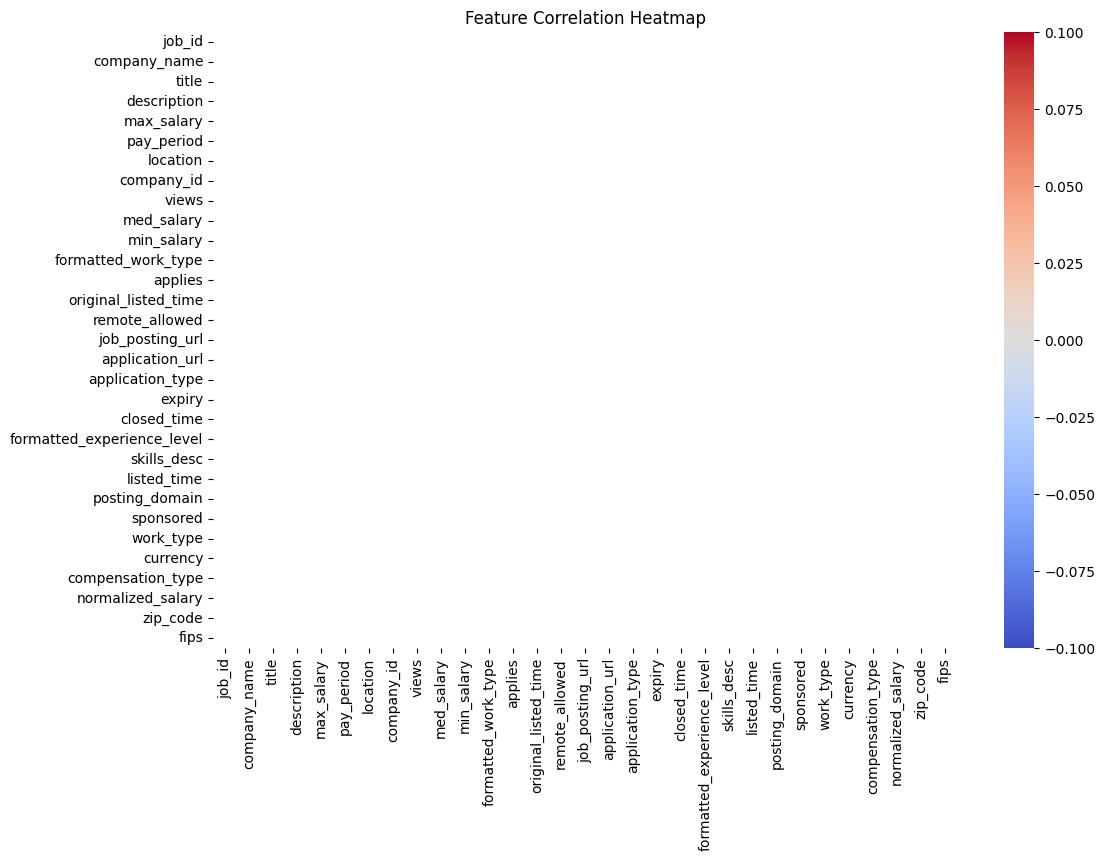

KeyError: "['max_salary_scaled'] not found in axis"

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from scipy.stats import zscore

# Load the dataset
path = "C:/Users/KIIT/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13/postings.csv"
df = pd.read_csv(path)

# ------------------ 1. DATA CLEANING ------------------ #

# Handling missing values
df.dropna(subset=["title", "location"], inplace=True)  # Essential fields should not be null
df["max_salary"].fillna(df["max_salary"].median(), inplace=True)  # Fill salary with median
df.fillna("Unknown", inplace=True)  # Fill other missing values with "Unknown"

# Removing duplicates
df.drop_duplicates(inplace=True)

# Handling outliers using Z-score
numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns
z_scores = np.abs(zscore(df[numeric_columns]))
df = df[(z_scores < 3).all(axis=1)]

# ------------------ 2. DATA TRANSFORMATION ------------------ #

# Ensure max_salary is numeric
df["max_salary"] = pd.to_numeric(df["max_salary"], errors="coerce")

# Drop NaN values in max_salary after conversion
df.dropna(subset=["max_salary"], inplace=True)

# Apply Min-Max scaling only if data exists
if not df["max_salary"].empty:
    scaler = MinMaxScaler()
    df["max_salary_scaled"] = scaler.fit_transform(df[["max_salary"]])
    
    standard_scaler = StandardScaler()
    df["max_salary_standardized"] = standard_scaler.fit_transform(df[["max_salary"]])
else:
    print("Warning: No valid max_salary values for scaling.")

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


# ------------------ 3. FEATURE SELECTION ------------------ #

# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Dropping highly correlated redundant columns
df.drop(columns=["max_salary_scaled"], inplace=True)

# ------------------ 4. FEATURE ENGINEERING ------------------ #

# Extracting job title keywords
df["title_keywords"] = df["title"].apply(lambda x: x.split()[0] if isinstance(x, str) else "Unknown")

# Extracting city from location
df["city"] = df["location"].apply(lambda x: x.split(",")[0] if isinstance(x, str) else "Unknown")

# ------------------ 5. DATA VISUALIZATION ------------------ #

# Salary distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["max_salary"], bins=30, kde=True)
plt.title("Salary Distribution")
plt.show()

# Job postings per city
plt.figure(figsize=(12, 5))
df["city"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Cities with Most Job Postings")
plt.show()

# ------------------ 6. K-MEANS CLUSTERING ------------------ #

# Selecting numerical columns for clustering
if "max_salary_standardized" in df.columns:
    clustering_features = df[["max_salary_standardized"]]
    
    # Finding optimal K using Elbow Method
    inertia = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(clustering_features)
        inertia.append(kmeans.inertia_)
    
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal K")
    plt.show()
    
    # Applying K-Means
    optimal_k = 3  # Assume 3 based on elbow method analysis
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df["cluster"] = kmeans.fit_predict(clustering_features)
else:
    print("Warning: No valid data available for K-means clustering.")

# ------------------ 7. CLUSTER ASSESSMENT ------------------ #

# Histogram of clusters
if "cluster" in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df["cluster"], bins=optimal_k, discrete=True)
    plt.title("Cluster Distribution")
    plt.show()
else:
    print("Warning: Clustering was not performed.")

print("Data Processing Completed!")

